In [1]:
!git clone https://github.com/giorgiodemarchi/Brain-Tumor-Detection-CNN-vs-ViT.git

Cloning into 'Brain-Tumor-Detection-CNN-vs-ViT'...
remote: Enumerating objects: 4076, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 4076 (delta 3), reused 3 (delta 0), pack-reused 4064
Receiving objects: 100% (4076/4076), 93.39 MiB | 15.36 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (4605/4605), done.


In [2]:
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate

In [3]:
def load_image(image_path):
    with Image.open(image_path) as img:
        return img.copy()

df = pd.read_csv('Brain-Tumor-Detection-CNN-vs-ViT/metadata_rgb_only.csv', index_col=0)

df = df.iloc[:-1]  # Drop last row

df['image_data'] = None # Initialize column

# Read image data
for i, row in df.iterrows():
  label = row['class']
  path = row['image']

  if label == 'tumor':
      image_path = "Brain-Tumor-Detection-CNN-vs-ViT/Brain Tumor Data Set//Brain Tumor Data Set/Brain Tumor/" + path
  else:
      image_path = "Brain-Tumor-Detection-CNN-vs-ViT/Brain Tumor Data Set//Brain Tumor Data Set/Healthy/" + path

  df.loc[i, 'image_data'] = load_image(image_path)

df['label'] = np.where(df['class']=='tumor', 1, 0)

df = df[['label','image_data']]

In [4]:
def display_image_rescaled(image_array):
    """
    Displays a single image.

    Args:
        image (numpy.ndarray): The image to display.
    """
    # Rescale the image values to the range [0,255] if they're normalized
    if image_array.max() <= 1.0:
        image_array = (image_array * 255).astype('uint8')
    plt.imshow(image_array, cmap='gray' if len(image_array.shape) == 2 else None)
    plt.axis('off')
    plt.show()

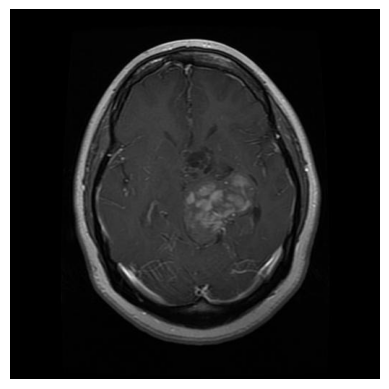

In [5]:
display_image_rescaled(np.array(df.iloc[0]['image_data']))

In [6]:
def normalize_luminosity(image):
    """
    Function to normalize image luminosity.
    To preserve the color information while equalizing the luminosity,
    we need to convert the image to a different color space that separates luminosity and color information,
    such as the LAB or YCbCr color space, normalize the luminosity channel, and then convert back to the RGB color space.
    """
    # Convert the image to the YCbCr color space
    ycbcr = image.convert('YCbCr')

    # Split the image into Y, Cb, and Cr channels
    y, cb, cr = ycbcr.split()

    # Equalize the histogram of the Y channel (luminosity)
    y = ImageOps.equalize(y)

    # Merge the equalized Y channel with the original Cb and Cr channels
    equalized_ycbcr = Image.merge('YCbCr', (y, cb, cr))

    # Convert back to the RGB color space
    equalized_rgb = equalized_ycbcr.convert('RGB')

    return equalized_rgb

df['image_data'] = df['image_data'].apply(normalize_luminosity)

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])

In [8]:
def resize_images_in_dataframe(df, target_size=(128, 128)):
    resized_df = df.copy()
    resized_df['image_data'] = df['image_data'].apply(lambda img: img.resize(target_size))
    return resized_df

train_df = resize_images_in_dataframe(train_df, target_size=(128, 128))
test_df = resize_images_in_dataframe(test_df, target_size=(128, 128))

In [9]:
def augment_data(df, augmentations_per_row=1):
    """
    Augment data by randomly applying transformation (same for all images in the row).
    """
    # Create an instance of the ImageDataGenerator class
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Lists to store augmented images and labels
    augmented_images_list = []
    labels = []
    data = {}

    # Iterate through each row of the dataframe
    for _, row in df.iterrows():

        image = row['image_data']
        image_array = np.array(image)

        label = row['label']

        for _ in range(augmentations_per_row):
            # Get the transformation parameters for data augmentation
            transform_params = datagen.get_random_transform(image_array.shape)

            augmented_row_image = datagen.apply_transform(image_array, transform_params)

            augmented_images_list.append(Image.fromarray(augmented_row_image.astype('uint8')))
            labels.append(label)

    # Convert lists into DataFrame columns
    data['image_data'] = augmented_images_list
    data['label'] = labels

    # Create a new DataFrame
    augmented_df = pd.DataFrame(data)

    return augmented_df

In [10]:
augmented_train_df = augment_data(train_df, augmentations_per_row=10)

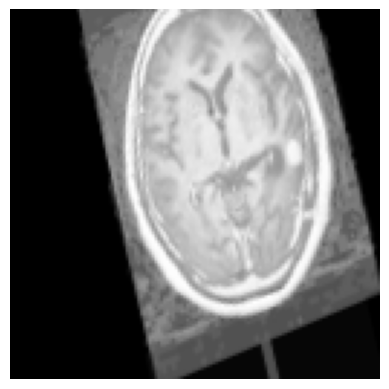

In [11]:
display_image_rescaled(np.array(augmented_train_df.iloc[0]['image_data']))

In [18]:
augmented_train_df['image_data'].to_numpy().shape

(31220,)

In [23]:
augmented_train_df['image_data_np'] = augmented_train_df['image_data'].apply(np.array)
test_df['image_data'] = test_df['image_data'].apply(np.array)

X_train = augmented_train_df['image_data_np'].to_numpy()
y_train = augmented_train_df['label'].to_numpy()

X_test = test_df['image_data'].to_numpy()
y_test = test_df['image_data'].to_numpy()

In [26]:
X_train[0].shape

(128, 128, 3)

In [ ]:
np.stack(X_train).shape

CNN Transfer model from MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2